# Unobserved zero/spot curve from traded bonds

A zero/spot curve resembles a curve of interest rates that present the cost of borrowing/lending from today/now/spot to the maturity on the x-axis on the curve. This is however a theoretical rate since it is not given that we can observe these interest rates directly. Take for instance a zero curve retrieved from bond prices. To get a clear view of the interest rates, we would need to have an actively traded zero-coupon bond for every maturity of interest. 

In practice, lots of disturbing forces are at play. Some bonds bear coupons, which distort the measure of underlying zero rates. Moreover, there might not be an (actively traded) instrument for each maturity. Especially when a set of bonds consists of coupon bearing bonds, it is likely that there will be points on the zero curve, where we don't have a bond price, but we do have a coupon to discount. This presents a case where there are more variables (zero rates) than equations (bond prices). Lastly, the time to maturity of bonds is ever changing and finding bonds for specific benchmark maturities (3m, 6m, 2y, 5y, etc.) might be difficult. 

In this notebook we will deal with a set of bonds where some of them are coupon bearing, and where some maturities don't have an actively traded instrument but do have a coupon payment. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### The True Zero Curve

Let's define our true zero curve to have a reference point for our future calculations and estimations. See below the true zero rates and subsequently we define a set of bonds that adhere to this zero curve, however, containing distortions as the ones described above. 

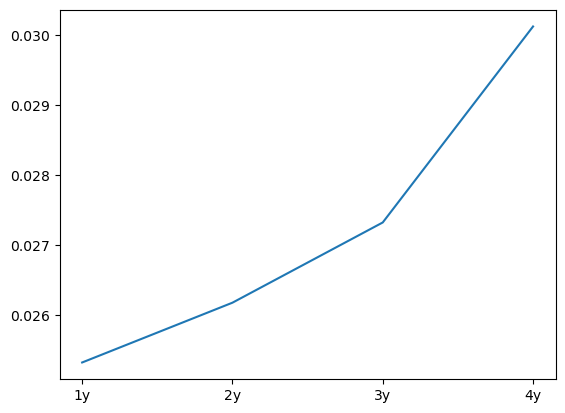

In [20]:
# True values for the zero curve
true_zero_curve = pd.DataFrame({
    '1y': {'tau': 1.00, 'zero_rate': 0.025317808},
    '2y': {'tau': 2.00, 'zero_rate': 0.026173240},
    '3y': {'tau': 3.00, 'zero_rate': 0.027321},
    '4y': {'tau': 4.00, 'zero_rate': 0.030125},
})

plt.plot(true_zero_curve.loc['zero_rate'])
plt.show()

In [ ]:


# note that the prices in the dictionary are derived from the true zero rates. From bond 1 and 2 we should be able to retrieve 
# the correct rate by simply solving for the zero rate. From 3y point onwards it becomes a bit more foggy. 
dict = {
    'bond1': {
        'coupon': 0.00,
        'time_to_maturity': 1.00,
        'price': 97.50,
        'coupon_freq': int(1),
    },

    'bond2': {
        'coupon': 0.00,
        'time_to_maturity': 2.00,
        'price': 94.90,
        'coupon_freq': int(1),
    },

    'bond3': {
        'coupon': 2.00,
        'time_to_maturity': 4.00,
        'price': 96.11078,
        'coupon_freq': int(1),
    }
}

df = pd.DataFrame(dict)
df

,bond1,bond2,bond3
coupon,0.0,0.0,2.00000
time_to_maturity,1.0,2.0,4.00000
price,97.5,94.9,96.11078
coupon_freq,1.0,1.0,1.00000


In [3]:
time = [1.00, 2.00, 3.00, 4.00]
bonds = df.columns
cash_flows = pd.DataFrame(0, index=bonds, columns=time)

for bond in bonds:
    cpn = df.loc['coupon', bond] / df.loc['coupon_freq', bond]
    tau = df.loc['time_to_maturity', bond] 

    for t in time:
        if t < tau:    
            cash_flows.loc[bond, t] = cpn
        if t==tau: 
            cash_flows.loc[bond, t] = 100 + cpn



cash_flows



,1.0,2.0,3.0,4.0
bond1,100,0,0,0
bond2,0,100,0,0
bond3,2,2,2,102


#### Optimize for bond 1

Note, that we could just use a closed-form solution and get the same answer. However, we are building up to a method for very general cases and don't want to be stuck with getting closed-form expressions all the time.

Essentially, we do the following. 

1. Get all the cash flows in the bond
2. Get the price
3. Use an initial guess for our first zero rate r1
4. Solve using quadratic optimization for r1 given that we have a system of 1 linear equation and 1 degree of freedom (the zero rate)

In [28]:
np.zeros(len(time))

array([0., 0., 0., 0.])

In [30]:
zero_rates = np.zeros(len(time))

def pv1(r1):
    zero_rates[0] = r1
    cash_flows_bond1 = cash_flows.loc['bond1', :] 
    price = df.loc['price', 'bond1']
    discount_factors = np.exp(-zero_rates * time)

    return( (np.dot(cash_flows_bond1, discount_factors) - price)**2 )


r1 = minimize(fun=pv1, x0=0.02).x[0]


C:\Users\joris\AppData\Local\Temp\ipykernel_11256\1361613647.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[0] = r1


#### Check with Closed-Form Solution

if $P_1=97.5$, then with continuous compounding interest it holds that $100e^{-r_1 * t_1} = P_1$. Now, substituting in our values for $P_1$ and $t_1=1$, we get

$$ r_1 = \frac{-1}{t_1} \ln(P_1/100) = - \ln(97.50/100) = 0.025317808, $$

which is up to 7 decimal places equivalent to our numerically obtained solution (see below).

In [5]:
zero_rates[0]

0.0253178154358983

#### Optimize for bond 2 

On to bond 2 and see whether there is a pattern to be found. Again we find a rate that seems to agree with our observed prices, and we obtain $r_2$.

In [6]:
# note that function is named differently but ultimately we are seeking a pattern that can generalize
def pv2(r2):
    zero_rates[1] = r2 # just assign the second zero rate
    cash_flows_bond2 = cash_flows.loc['bond2', :] # likewise indicate that it is the second bond/instrument
    price = df.loc['price', 'bond2']
    discount_factors = np.exp(-zero_rates * time) # already generic

    return( (np.dot(cash_flows_bond2, discount_factors) - price)**2 )


r2 = minimize(fun=pv2, x0=0.02).x[0] # assign new value to r2

C:\Users\joris\AppData\Local\Temp\ipykernel_11256\91618923.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[1] = r2 # just assign the second zero rate
C:\Users\joris\AppData\Local\Temp\ipykernel_11256\91618923.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[1] = r2 # just assign the second zero rate


#### Closed-Form Solution for $r_2$

$$ r_2 = \frac{-1}{t_2} \ln(P_2 / 100) = \frac{-1}{2} \ln(94.9 / 100) = 0.026173240, $$

which is again equivalent to our numeric solution up to 7 decimal places. 

In [7]:
zero_rates[1]

0.02617323585284772

#### No observed instrument

Now, we are at $t=3$ which puts us in a tough spot. We don't have an observed price of a bond for this time to maturity. However, we do have a cash flow occuring at this moment in time, and we should come up with a zero rate $r_3$ to be able to properly back out the next zero rate $r_4$. Indeed, if we ignore $r_3$ at $t=3$, we will get a system with one equation and 2 unknowns at time $t=4$. 

Since there is no one way of retrieving our next zero rate, there are lots of possibilities. I will follow Hull's suggestion to interpolate prices between $t=2$ and $t=4$. To do that, I thought it would make more sense to synthetically create a bond with the same coupon as the one at $t=4$ such that the linear interpolation between the two points makes more sense. 

TODO: also try without synthetic instrument

In [8]:
def pv3(r3):
    zero_rates[2] = 0
    discount_factors = np.exp( - zero_rates * time )
    synthetic_cpn = 2.0  
    synthetic_tau = 2.0
    cash_flows_synth = pd.DataFrame(0, index=['synthetic_bond'], columns=time)
    
    # Create synthetic bond 
    for t in time:
        
        if t < synthetic_tau: 
            cash_flows_synth.loc['synthetic_bond', t] = synthetic_cpn
        if t == synthetic_tau:
            cash_flows_synth.loc['synthetic_bond', t] = 100 + synthetic_cpn
    
    price_synt2 = np.dot(discount_factors, cash_flows_synth.loc['synthetic_bond'].values)
    
    # interpolation
    tau2 = synthetic_tau
    tau3 = time[2]
    tau4 = time[3]
    price4 = df.loc['price', 'bond3']
    interpolated_price = price_synt2 + (price4 - price_synt2)/(tau4 - tau2) * (tau3 - tau2) 
    
    # go through original process but with the synthetc bond price
    zero_rates[2] = r3 # just assign the third zero rate
    discount_factors = np.exp(-zero_rates * time) # already generic

    interpolated_cpn = 2.0  
    interpolated_tau = 3.0
    cash_flows_int = pd.DataFrame(0, index=['interpolated_bond'], columns=time)
    for t in time:
        
        if t < interpolated_tau: 
            cash_flows_int.loc['interpolated_bond', t] = interpolated_cpn
        if t == interpolated_tau:
            cash_flows_int.loc['interpolated_bond', t] = 100 + interpolated_cpn

    interpolated_cash_flows = cash_flows_int.loc['interpolated_bond'].values # likewise indicate that it is the third bond/instrument

    return( (np.dot(interpolated_cash_flows, discount_factors) - interpolated_price)**2 )

r3 = minimize(fun=pv3, x0=0.02, method="BFGS").x[0] # assign new value to r3

C:\Users\joris\AppData\Local\Temp\ipykernel_11256\584375283.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[2] = r3 # just assign the third zero rate


In [9]:
zero_rates

array([0.02531782, 0.02617324, 0.02871376, 0.        ])

#### Retrievement of zero rate from non-observed prices

So, by construction we defined a zero rate for $r_3$ as ... . Logically, we are not able to exactly retrieve this value by interpolation, but we are able to narrowly estimate it. It follows that a curve where actively traded securities are available for more maturities, improves price discovery, and thus, increases the likelihood of finding zero rates that are close to the truth. 

For the fourth rate we can use our previously developed method without the need of interpolation. Let's dig in to see whether we can find $r_4$ close to its 'true' value. 

In [13]:
# note that function is named differently but ultimately we are seeking a pattern that can generalize
def pv4(r4):
    zero_rates[3] = r4 # just assign the second zero rate
    cash_flows_bond3 = cash_flows.loc['bond3', :] # likewise indicate that it is the second bond/instrument
    price = df.loc['price', 'bond3']
    discount_factors = np.exp(-zero_rates * time) # already generic

    return( (np.dot(cash_flows_bond3, discount_factors) - price)**2 )


r4 = minimize(fun=pv4, x0=0.02).x[0] # assign new value to r2

C:\Users\joris\AppData\Local\Temp\ipykernel_11256\4169847530.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[3] = r4 # just assign the second zero rate


In [14]:
zero_rates

array([0.02531782, 0.02617324, 0.02871376, 0.03010513])

#### Estimated vs True Zero Curve

How well did we do? Since we defined this exercise ourselves, we have a set of 'true' zero rates. We'll lay them next to the estimated zero rates and see the difference.

We can see that if we plot the two curves in a graph, it seems like the year 1, 2 and 4 are very well estimated, while year 3 is a bit off (which is the maturity without traded bond price).

If we dig some deeper into the difference we see that in bps, the difference between the 'true' and estimated zero rates is negligble for maturity 1y, 2y and 4y. For the 3y point the difference is 0.133 bps which is in many cases acceptable. Further investigation is needed to assess how these discrepancies behave when a curve consists of more points and more gaps, especially when time to maturity increases, it could be that differences magnify. 

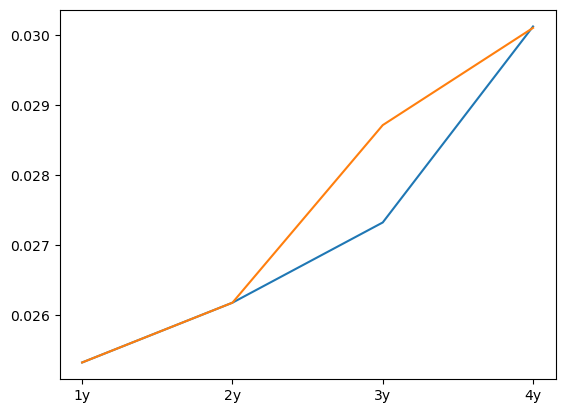

In [22]:
true_zero_rates = true_zero_curve.loc['zero_rate']
plt.plot(true_zero_rates)
plt.plot(zero_rates)
plt.show()

In [26]:
difference_bps = 100*(true_zero_rates - zero_rates)
print(f'The difference in bps between true and estimated zero rates is\n {difference_bps.round(3)}')

The difference in bps between true and estimated zero rates is
 1y   -0.000
2y    0.000
3y   -0.139
4y    0.002
Name: zero_rate, dtype: float64


#### Generalizing results

Now, we'll take a good look at the before defined functions and see whether we can generalize some things to make our lives easier. 

Eventually, we'll need a Curve Class as well.

In [ ]:
# note that function is named differently but ultimately we are seeking a pattern that can generalize

current_bond = 'bond1'
zero_rates = np.zeros(len(time))

def present_value_constructor(zero_rate_i, idx):
    if time[idx] == df.loc['time_to_maturity', current_bond]:
        zero_rates[idx] = zero_rate_i # just assign the second zero rate
        cash_flows_i = cash_flows.loc[current_bond, :] # likewise indicate that it is the second bond/instrument
        price = df.loc['price', current_bond]
        discount_factors = np.exp(-zero_rates * time) # already generic
    else:
        # synthetic bond
        synth_cpn = 

    return( (np.dot(cash_flows_i, discount_factors) - price)**2 )

for i, tau in enumerate(time):

    zero_rates[i] = minimize(fun=present_value_constructor, x0=0.02, args=(i)).x[0] # assign new value to r2

    

In [ ]:
def pv3(r3):
    zero_rates[2] = 0
    discount_factors = np.exp( - zero_rates * time )
    synthetic_cpn = 2.0  
    synthetic_tau = 2.0
    cash_flows_synth = pd.DataFrame(0, index=['synthetic_bond'], columns=time)
    
    # Create synthetic bond 
    for t in time:
        
        if t < synthetic_tau: 
            cash_flows_synth.loc['synthetic_bond', t] = synthetic_cpn
        if t == synthetic_tau:
            cash_flows_synth.loc['synthetic_bond', t] = 100 + synthetic_cpn
    
    price_synt2 = np.dot(discount_factors, cash_flows_synth.loc['synthetic_bond'].values)
    
    # interpolation
    tau2 = synthetic_tau
    tau3 = time[2]
    tau4 = time[3]
    price4 = df.loc['price', 'bond3']
    interpolated_price = price_synt2 + (price4 - price_synt2)/(tau4 - tau2) * (tau3 - tau2) 
    
    # go through original process but with the synthetc bond price
    zero_rates[2] = r3 # just assign the third zero rate
    discount_factors = np.exp(-zero_rates * time) # already generic

    interpolated_cpn = 2.0  
    interpolated_tau = 3.0
    cash_flows_int = pd.DataFrame(0, index=['interpolated_bond'], columns=time)
    for t in time:
        
        if t < interpolated_tau: 
            cash_flows_int.loc['interpolated_bond', t] = interpolated_cpn
        if t == interpolated_tau:
            cash_flows_int.loc['interpolated_bond', t] = 100 + interpolated_cpn

    interpolated_cash_flows = cash_flows_int.loc['interpolated_bond'].values # likewise indicate that it is the third bond/instrument

    return( (np.dot(interpolated_cash_flows, discount_factors) - interpolated_price)**2 )

r3 = minimize(fun=pv3, x0=0.02, method="BFGS").x[0] # assign new value to r3